In [1]:
# simulation.py

import pandas as pd
import numpy as np
import torch
from typing import List
import matplotlib.pyplot as plt
from lstm import F1PredictionModel, load_model_with_preprocessor, F1DataPreprocessor
from race_simulator_NN import Race, RaceSimulator, Driver, plot_lap_times, plot_race_positions
from features import RaceFeatures
import logging

# Load the trained model and preprocessor
model_path = 'models/lstm_model.pth'
model, preprocessor = load_model_with_preprocessor(model_path)

def get_race_length(race_id: int, lap_times_df: pd.DataFrame) -> int:
    """
    Get the actual race length for a given race ID from historical data.
    """
    race_laps = lap_times_df[lap_times_df['raceId'] == race_id]['lap'].max()
    if pd.isna(race_laps):
        # Fallback to a default length if race not found
        return 50
    return int(race_laps)

# When creating the Race instance:
lap_times = pd.read_csv('../data/raw_data/lap_times.csv', na_values=['\\N', 'NaN', ''])
race_length = get_race_length(1000, lap_times)  # Use your actual race ID

# Create an instance of the Race with actual length
race = Race(
    race_id=1000,
    circuit_id=1,
    total_laps=race_length,
    weather_conditions={},
    safety_car_periods=[(10, 12)]
)

# Load driver attributes    
drivers_df = pd.read_csv('data/util/drivers_attributes.csv')

# Create an instance of RaceFeatures
race_features = RaceFeatures()

def initialize_drivers(drivers_df: pd.DataFrame, preprocessor: F1DataPreprocessor, race_features: RaceFeatures, race: Race) -> List[Driver]:
    drivers = []

    # Filter driver attributes for the specific raceId
    drivers_df = drivers_df[drivers_df['raceId'] == race.race_id]

    if drivers_df.empty:
        raise ValueError(f"No drivers found for raceId {race.race_id}")

    for idx, row in drivers_df.iterrows():
        static_features_dict = {
            'driver_overall_skill': row['driver_overall_skill'],
            'driver_circuit_skill': row['driver_circuit_skill'],
            'driver_consistency': row['driver_consistency'],
            'driver_reliability': row['driver_reliability'],
            'driver_aggression': row['driver_aggression'],
            'driver_risk_taking': row['driver_risk_taking'],
            'constructor_performance': row['constructor_performance'],
            'fp1_median_time': row['fp1_median_time'],
            'fp2_median_time': row['fp2_median_time'],
            'fp3_median_time': row['fp3_median_time'],
            'quali_time': row['quali_time'],
            'circuitId': race.circuit_id
        }

        # Extract features in the correct order
        static_features = np.array([static_features_dict[feature] for feature in preprocessor.static_feature_names])

        # Assign a starting tire compound (e.g., medium = 2)
        starting_tire_compound = 2

        driver = Driver(
            driver_id=row['driverId'],
            name=f"Driver {row['driverId']}",
            static_features=static_features,
            initial_dynamic_features={
                'tire_age': 0,
                'fuel_load': 100.0,
                'track_position': idx + 1,
                'TrackTemp': 35.0,
                'AirTemp': 25.0,
                'Humidity': 50.0,
                'TrackStatus': 1,
                'is_pit_lap': 0,
                'tire_compound': starting_tire_compound  # Add starting tire compound
            },
            start_position=idx + 1,
            pit_strategy=[(25, 3)],  # Example pit strategy to switch to soft tires
            starting_compound=starting_tire_compound
        )

        # Scale static features using the preprocessor
        driver.static_features = preprocessor.transform_static_features(static_features).flatten()

        # Initialize sequence with zeros
        driver.sequence = np.zeros((3, len(race_features.dynamic_features) + 1))  # +1 for lap time

        drivers.append(driver)

    logging.info(f"Initialized {len(drivers)} drivers for raceId {race.race_id}")
    return drivers




# Initialize drivers using updated features
drivers = initialize_drivers(drivers_df, preprocessor, race_features, race)

# Add drivers to the race
race.drivers.extend(drivers)

# Simulate the race
simulator = RaceSimulator(model, preprocessor)
race_lap_data = simulator.simulate_race(race)


# Proceed with analysis and plotting



/Users/I551659/Documents/GitHub/IE650-RAMP/ie500-data-mining-group7/lap_simulation/lstm.py:235: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, m

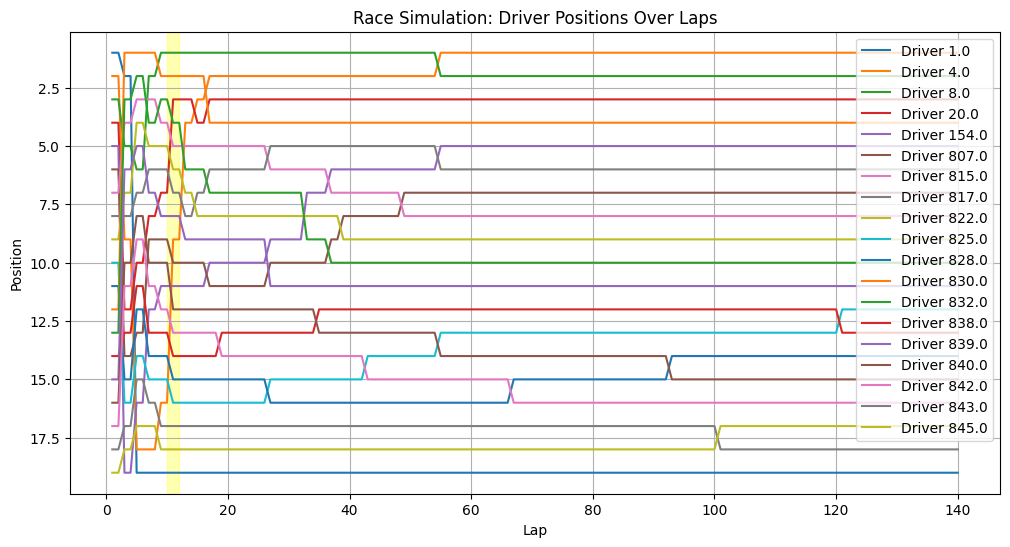

In [2]:
plot_race_positions(race)

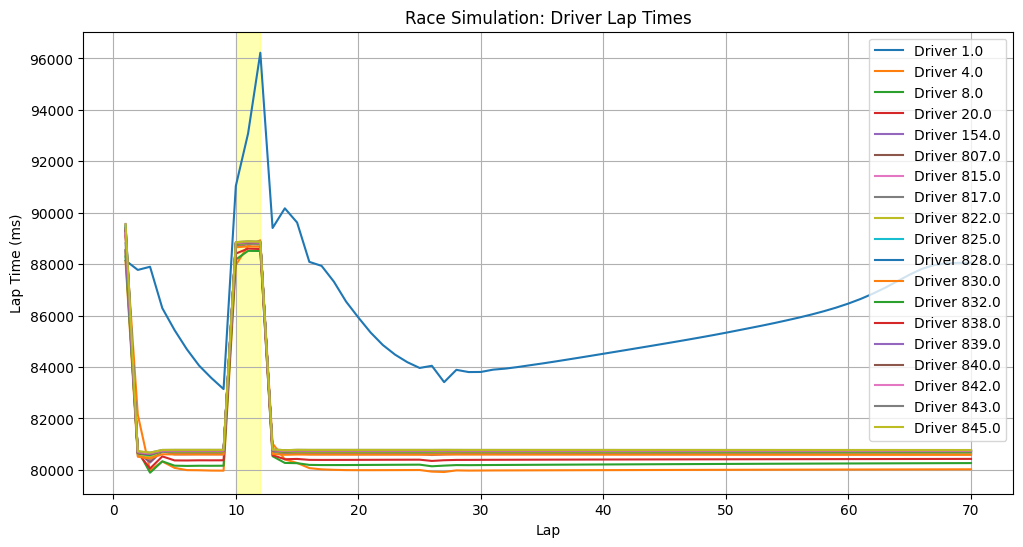

In [3]:
plot_lap_times(race)